# Nebula Storage

The Nebula storage is an object capable of storing any kind of data (list, integers, dataframes, etc) that lives within the python process, without physically writing any data.

Its utility spans several purposes:
- passing data and dataframes across transformers (let's suppose you need to perform a join, a transformer inherently takes as input just one single dataframe, you need a way pass the second one.)
- storing data and intermediary dataframes, aiding in the debugging process
- helping the developer to debug a broken pipeline within a notebook (see next notebook, number `05`)

In [1]:
import sys

from pyspark.sql import functions as F
from pyspark.sql.types import *

import yaml

from nebula.spark_transformers import *
from nebula.base import Transformer
from nebula.pipelines.pipelines import TransformerPipeline
from nebula.pipelines.pipeline_loader import load_pipeline
from nebula.storage import nebula_storage as ns

py_version = ".".join(map(str, (sys.version_info[0:2])))
print("python version:", py_version)

python version: 3.7


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
schema = [
    StructField("c1", FloatType(), True),
    StructField("c2", StringType(), True),
    StructField("c3", StringType(), True),
]

data = [
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [0.1234, "a", "b"],
    [1.1234, "a", "  b"],
    [2.1234, "  a  ", "  b  "],
    [3.1234, "", ""],
    [4.1234, "   ", "   "],
    [5.1234, None, None],
    [6.1234, " ", None],
    [7.1234, "", None],
    [8.1234, "a", None],
    [9.1234, "a", ""],
    [10.1234, "   ", "b"],
    [11.1234, "a", None],
    [12.1234, None, "b"],
    [13.1234, None, "b"],
    [14.1234, None, None],
]

df_input = spark.createDataFrame(data, schema=StructType(schema)).cache()
df_input.show()

+-------+-----+-----+
|     c1|   c2|   c3|
+-------+-----+-----+
| 0.1234|    a|    b|
| 0.1234|    a|    b|
| 0.1234|    a|    b|
| 1.1234|    a|    b|
| 2.1234|  a  |  b  |
| 3.1234|     |     |
| 4.1234|     |     |
| 5.1234| null| null|
| 6.1234|     | null|
| 7.1234|     | null|
| 8.1234|    a| null|
| 9.1234|    a|     |
|10.1234|     |    b|
|11.1234|    a| null|
|12.1234| null|    b|
|13.1234| null|    b|
|14.1234| null| null|
+-------+-----+-----+



## Create a pipeline with two custom transformers using python

- `SetToNebulaStorage`: sets some values in nebula storage
- `ReadFromNebulaStorage`: reads from nebula storage

Values can be stored either as standard values or as debug values by adding the parameter `debug=True`.

In the latter case the debug values are not actually stored unless the debug mode is active. It can be activated / deactivaed by calling `nebula_storage.allow_debug(True / False)`.

This feature empowers users to store extensive data for debugging purposes and then refrain from storing it when transitioning the code into production simply by turning off the debug mode through `nebula_storage.allow_debug(False)` without modifying the code.

It's important to note that the storage for standard values and debug values is shared, so careful attention is needed to avoid unintentional overrides.

Additionally, there is the option to allow or disallow the overwriting mode. When overwriting is disallowed, attempting to store a value twice with the same key (without clearing it) and overwriting the previous value will throw a `KeyError`.

In [2]:
from nebula.storage import nebula_storage as ns


class SetToNebulaStorage:
    @staticmethod
    def transform(df):
        ns.set("this_key", 10)
        
        ns.allow_debug(False)
        # Deactivate the debug storage
        ns.set("debug_value_1", "value_1", debug=True)  # This value will not be stored
        
        ns.allow_debug(True)
        ns.set("debug_value_2", "value_2", debug=True)
        return df


class ReadFromNebulaStorage:
    @staticmethod
    def transform(df):
        value = ns.get("this_key")
        print(f"------- read: {value} -------")
        return df


pipe = TransformerPipeline([
    SetToNebulaStorage(),
    ReadFromNebulaStorage(),
])

pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline *** (2 transformers)
 - SetToNebulaStorage
 - ReadFromNebulaStorage


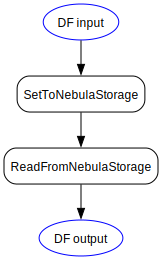

In [3]:
pipe.plot_dag()

In [6]:
df_out = pipe.run(df_input)

2024-05-16 14:10:34,333 | pipelines.py:516 [INFO]: Running *** TransformerPipeline *** (2 transformers) 
2024-05-16 14:10:34,342 | pipelines.py:283 [INFO]: Running SetToNebulaStorage ... 
2024-05-16 14:10:34,343 | storage.py:124 [INFO]: Nebula Storage: setting an object (<class 'int'>) with the key "this_key". 
2024-05-16 14:10:34,343 | storage.py:89 [INFO]: Nebula Storage: deactivate debug storage. 
2024-05-16 14:10:34,344 | storage.py:134 [INFO]: Nebula Storage: asked to set "debug_value_1" in debug mode but the storage debug is not active. The object will not be stored. 
2024-05-16 14:10:34,344 | storage.py:87 [INFO]: Nebula Storage: activate debug storage. 
2024-05-16 14:10:34,345 | storage.py:124 [INFO]: Nebula Storage: setting an object (<class 'str'>) with the key "debug_value_2". 
2024-05-16 14:10:34,345 | pipelines.py:297 [INFO]: Execution time for SetToNebulaStorage: 0.0s 
2024-05-16 14:10:34,346 | pipelines.py:283 [INFO]: Running ReadFromNebulaStorage ... 
2024-05-16 14:10:3

------- read: 10 -------


### Nebula storage methods and properties

- `is_overwriting_allowed` (_property_): return wether the overwrting is allowed
- `is_debug_mode` (_property_): return wether the debug mode is allowed
- `allow_overwriting()` (_method_): allow the overwriting mode
- `disallow_overwriting()` (_method_): disallow the overwriting mode
- `allow_debug(bool)` (_method_): allow / disallow debug mode
- `list_keys()` (_method_): return the current keys as a sorted list
- `count_objects()` (_method_): return the number of stored objects
- `clear(str | list(str) | None)` (_method_): clear all cache or remove some specific key(s).
- `get(str)` (_method_): return the object stored with the provided key
- `isin(str)` (_method_): check if the provided key exists

In [7]:
print(f"overwriting mode: {ns.is_overwriting_allowed}")
print(f"debug mode: {ns.is_debug_mode}")
print(f"current keys: {ns.list_keys()}")
print(f"number of stored objects: {ns.list_keys()}")

overwriting mode: True
debug mode: True
current keys: ['debug_value_2', 'this_key']
number of stored objects: ['debug_value_2', 'this_key']


#### Note that the `debug_value_1` is not stored because when attempted to store, the debug was not active

### Moreover, it is feasible to insert storage requests between transformers. 

This allows the pipeline dataframe to be stored between steps, enabling later reuse for debugging or in other transformers.

A storage request is a single-key dictionary, such as:
- `{"store": "key_x"}`: Store the intermediate dataframe with the key key_x
- `{"store_debug": "key_y"}`: Store the intermediate dataframe in debug mode with the key key_y
- `{"storage_debug_mode": True}`: activate the debug mode
- `{"storage_debug_mode": False}`: deactivate the debug mode

In [4]:
ns.clear()

pipe = TransformerPipeline([
    Limit(n=5),
    {"storage_debug_mode": False},
    {"store": "only-5-rows"},  # Store the dataframe
    Limit(n=3),
    {"store_debug": "this-key-will-be-skipped"},  # Store the dataframe in debug mode, but the debug mode is not active yet
    {"storage_debug_mode": True},  # Turn on debug mode
    {"store_debug": "only-3-rows"},  # Store the dataframe in debug mode
    {"storage_debug_mode": False},  # Turn off debug mode
])

pipe.show_pipeline(add_transformer_params=True)

2024-08-25 15:41:32,181 | storage.py:108 [INFO]: Nebula Storage: clear. 
2024-08-25 15:41:32,183 | storage.py:118 [INFO]: Nebula Storage: 0 keys remained after clearing. 


*** TransformerPipeline *** (2 transformers)
 - Limit -> PARAMS: n=5
   --> Deactivate storage debug mode
   --> Store the dataframe with the key "only-5-rows"
 - Limit -> PARAMS: n=3
   --> Store the dataframe with the key "this-key-will-be-skipped" in debug mode"
   --> Activate storage debug mode
   --> Store the dataframe with the key "only-3-rows" in debug mode"
   --> Deactivate storage debug mode


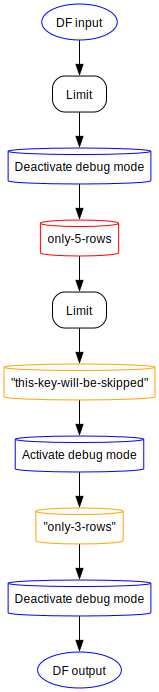

In [5]:
pipe.plot_dag()

## Create the same pipeline using yaml

In [10]:
yml_data = """
pipeline:
  - transformer: Limit
    params:
        n: 5
  - storage_debug_mode: False
  - store: "only-5-rows"
  - transformer: Limit
    params:
        n: 3
  - store_debug: "this-key-will-be-skipped"
  - storage_debug_mode: True
  - store_debug: "only-3-rows"
  - storage_debug_mode: False
"""

pipe_cfg = yaml.safe_load(yml_data)

pipe = load_pipeline(pipe_cfg)

pipe.show_pipeline(add_transformer_params=True)

*** TransformerPipeline *** (2 transformers)
 - Limit -> PARAMS: n=5
   --> Deactivate storage debug mode
   --> Store the dataframe with the key "only-5-rows"
 - Limit -> PARAMS: n=3
   --> Store the dataframe with the key "this-key-will-be-skipped" in debug mode"
   --> Activate storage debug mode
   --> Store the dataframe with the key "only-3-rows" in debug mode"
   --> Deactivate storage debug mode


In [11]:
ns.clear()

pipe.run(df_input).show()

2024-05-16 14:10:34,719 | storage.py:108 [INFO]: Nebula Storage: clear. 
2024-05-16 14:10:34,719 | storage.py:118 [INFO]: Nebula Storage: 0 keys remained after clearing. 
2024-05-16 14:10:34,720 | pipelines.py:516 [INFO]: Running *** TransformerPipeline *** (2 transformers) 
2024-05-16 14:10:34,721 | pipelines.py:283 [INFO]: Running Limit -> PARAMS: n=5 ... 
2024-05-16 14:10:34,725 | pipelines.py:297 [INFO]: Execution time for Limit: 0.0s 
2024-05-16 14:10:34,725 | pipelines.py:270 [INFO]:    --> Deactivate storage debug mode 
2024-05-16 14:10:34,726 | storage.py:89 [INFO]: Nebula Storage: deactivate debug storage. 
2024-05-16 14:10:34,726 | pipelines.py:260 [INFO]:    --> Store the dataframe with the key "only-5-rows" 
2024-05-16 14:10:34,727 | storage.py:124 [INFO]: Nebula Storage: setting an object (<class 'pyspark.sql.dataframe.DataFrame'>) with the key "only-5-rows". 
2024-05-16 14:10:34,727 | pipelines.py:283 [INFO]: Running Limit -> PARAMS: n=3 ... 
2024-05-16 14:10:34,730 | pip

+------+---+---+
|    c1| c2| c3|
+------+---+---+
|0.1234|  a|  b|
|0.1234|  a|  b|
|0.1234|  a|  b|
+------+---+---+



In [12]:
ns.list_keys()

['only-3-rows', 'only-5-rows']

### After the first `Limit(n=5)` transformer:

In [13]:
ns.get("only-5-rows").show()

+------+-----+-----+
|    c1|   c2|   c3|
+------+-----+-----+
|0.1234|    a|    b|
|0.1234|    a|    b|
|0.1234|    a|    b|
|1.1234|    a|    b|
|2.1234|  a  |  b  |
+------+-----+-----+



### After the second `Limit(n=3)` transformer:

In [14]:
ns.get("only-3-rows").show()

+------+---+---+
|    c1| c2| c3|
+------+---+---+
|0.1234|  a|  b|
|0.1234|  a|  b|
|0.1234|  a|  b|
+------+---+---+

